In [11]:
from IPython.display import clear_output
import matplotlib.pyplot as plt
from bsuite.environments import cartpole
from mbrlax.models import GPModelSpec, SVGP, initialize_gp_model
from mbrlax.utils import ReplayBuffer
from gpjax.likelihoods import Gaussian
import jax
import jax.numpy as jnp
from gpjax.parameters import build_constrain_params
from jax.example_libraries import optimizers
from gpjax.datasets import CustomDataset, NumpyLoader
import tensorflow as tf

In [2]:
!pip3 install tf-nightly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.6/228.6 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.8/5.8 MB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.8/438.8 KB 6.4 MB/s eta 0:00:00
  Using cached gast-0.4.0-py3-none-any.whl (9.8 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl (15 kB)
  Attempting uninstall: flatbuffers
    Found existing installation: flatbuffers 2.0
    Uninstalling flatbuffers-2.0:
      Successfully uninstalled flatbuffers-2.0
  Attempting uninstall: tf-estimator-nightly
    Found existing installation: tf-estimator-nightly 2.8.0.dev2021122109
    Uninstalling tf-estimator-nightly-2.8.0.dev2021122109:
      Successfully uninstalled tf-estimator-nightly-2.8.0.dev2021122109
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
ERROR: p

In [1]:
import gpflow

In [3]:
from gpflow_pilco.models.core import LabelledData
from gpflow_pilco.moment_matching import moment_matching

In [2]:
action_space = jnp.array([0,1,2])
replay_buffer = ReplayBuffer(5000)

In [12]:
x = jnp.array([1,2,3,4,5])
y = tf.constant(x)
y

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([1, 2, 3, 4, 5])>

## Collect experience (states, actions) and format it as input to the GP.

In [3]:
def random_policy(key):
    return jax.random.choice(key=key, a=action_space)

def generate_experience(env, key, num_steps=1000):
    time_step = env.reset()
    states, actions = [], []
    states.append(time_step.observation[0])
    for step in range(num_steps):
        action = random_policy(key)
        actions.append([action])
        time_step = env.step(action)
        if time_step.last(): time_step = env.reset()
        states.append(time_step.observation[0])

    return jnp.asarray(states), jnp.asarray(actions)

def get_gp_data(states, actions):
    inputs = jnp.concatenate(arrays=[states[:-1, :], actions], axis=1)
    targets = states[1:, :] - states[:-1, :]
    return inputs, targets

In [ ]:
seed = 42
key = jax.random.PRNGKey(seed)
env = cartpole.Cartpole(seed=seed)
states, actions = generate_experience(env=env, key=key)
inputs, targets = get_gp_data(states, actions)

In [9]:
def populate_replay_buffer(env, key, num_steps=1000):
    time_step = env.reset()
    print(type(time_step.observation))
    replay_buffer.push(time_step, None)
    for step in range(num_steps):
        action = random_policy(key)
        time_step = env.step(action)
        replay_buffer.push(env_output=time_step, action=action)
        if time_step.last(): time_step = env.reset()

In [10]:
seed = 42
replay_buffer.reset()
key = jax.random.PRNGKey(seed)
env = cartpole.Cartpole(seed=seed)
populate_replay_buffer(env=env, key=key)
obs_tm1, a_tm1, r_t, discount_t, obs_t = replay_buffer.sample(100)

assert(obs_tm1.shape == (100, 6))
assert(a_tm1.shape == (100,))
assert(discount_t.shape == (100,))
assert(r_t.shape == (100,))
assert(obs_t.shape == (100,6))

obs_tm1, a_tm1, r_t, discount_t, obs_t = replay_buffer.gather_all()
assert(obs_tm1.shape == (1000, 6))
assert(a_tm1.shape == (1000,))
assert(discount_t.shape == (1000,))
assert(r_t.shape == (1000,))
assert(obs_t.shape == (1000,6))

<class 'numpy.ndarray'>


In [ ]:
def test_replay_buffer():
    

## Initialise model

In [3]:
model_spec = GPModelSpec(
    type=SVGP,
    num_inducing=32,
    likelihood=Gaussian(),
    model_uncertainty=True,
)
model = initialize_gp_model(data=(inputs, targets), model_spec=model_spec)

In [4]:
model_params = model.get_params()
print(model_params.keys())
print(model_params['inducing_variable'].shape)

dict_keys(['kernel', 'likelihood', 'mean_function', 'inducing_variable', 'q_mu', 'q_sqrt'])
(32, 7)


In [5]:
model_transforms = model.get_transforms()
constrain_params = build_constrain_params(model_transforms)

## Train model

In [6]:
learning_rate = 1e-3
batch_size = 60
num_epochs = 900

# Create optimizer
opt_init, opt_update, get_params = optimizers.adam(learning_rate)

In [7]:
elbo = model.build_elbo(constrain_params=constrain_params, num_data=1000)

def negative_elbo(params, batch):
    return - elbo(params, batch)

@jax.jit
def train_step(step_i, opt_state, batch):
    params = get_params(opt_state)
    loss, grads = jax.value_and_grad(negative_elbo, argnums=0)(params, batch)
    return loss, opt_update(step_i, grads, opt_state)

In [8]:
data = (inputs, targets)
training_data = CustomDataset(inputs, targets)
train_dataloader = NumpyLoader(training_data, batch_size=batch_size, shuffle=True)

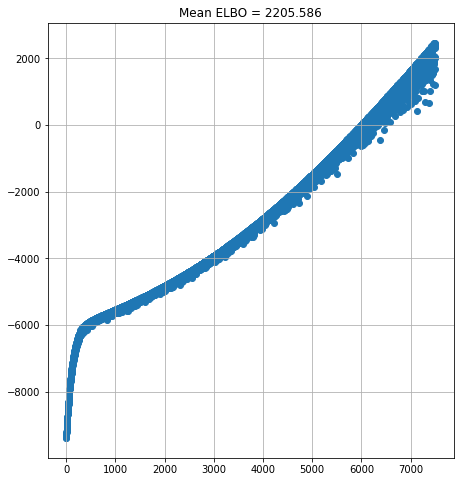

KeyboardInterrupt: 

In [13]:
opt_state = opt_init(model_params)
loss_history = []
for epoch in range(num_epochs):
    for batch in train_dataloader:  # iterate over batches
        x, y = batch
        loss, opt_state = train_step(epoch, opt_state, batch)
        params = get_params(opt_state)
        loss_history.append(loss.item())

    if epoch % 20 == 0:
        clear_output(True)
        plt.figure(figsize=[16, 8])
        plt.subplot(1, 2, 1)
        plt.title("Mean ELBO = %.3f" % -jnp.mean(jnp.array(loss_history[-32:])))
        plt.scatter(jnp.arange(len(loss_history)), jnp.array(loss_history)*-1.0)
        plt.grid()
        plt.show()